## Imports

### Libraries

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

### Custom

In [46]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model constants

In [3]:
NUMBER_OF_GRID_ELEMENTS = 100
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'

LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR


### ImageNet setup

In [25]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-05-15 22:45:39--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,001s  

2022-05-15 22:45:39 (12,4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [29]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Download ResNet50

In [26]:
resnet50 = models.resnet50(True, True)

In [27]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [34]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, 0.04)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some training images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


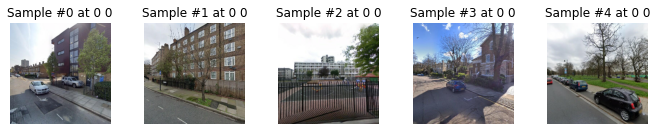

In [36]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)

plot_images(eval_images[:SAMPLES_TO_SHOW], eval_coordinates[:SAMPLES_TO_SHOW], IMAGENET_MEAN, IMAGENET_STD)

## Evaluate the model

In [44]:
resnet50.eval()

check_images = eval_images[:SAMPLES_TO_SHOW]
check_coordinates = eval_coordinates[:SAMPLES_TO_SHOW]

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(check_images), dim=1)

In [47]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print()

file 0.2891247868537903
moving van 0.1145564392209053
carton 0.09643592685461044
minivan 0.037023574113845825
cab 0.02975429780781269

prison 0.35264715552330017
palace 0.1462661325931549
traffic light 0.06560461968183517
castle 0.05644534155726433
monastery 0.035542961210012436

turnstile 0.2170325368642807
patio 0.196283221244812
pier 0.07392453402280807
bannister 0.07234904170036316
parking meter 0.07140535861253738

parking meter 0.07230779528617859
planetarium 0.056582801043987274
minivan 0.05045659840106964
shopping cart 0.04336711764335632
ashcan 0.041115958243608475

minivan 0.3569077253341675
limousine 0.07413613051176071
convertible 0.04769878461956978
car wheel 0.04443718120455742
jeep 0.03733822703361511



torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


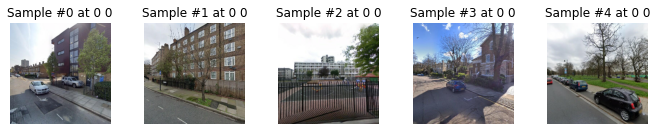

In [48]:
plot_images(check_images, check_coordinates, IMAGENET_MEAN, IMAGENET_STD)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)